In [53]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
courses = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_courses.csv')
logs = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_logs.csv')
regs = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_registrations.csv')
sections = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_sections.csv')
tasks = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_tasks.csv')
users = pd.read_csv('OneDrive/Área de Trabalho/mac434/anonimized_users.csv')

Iniciar aqui a seleção dos 25 mais ativos, utilizando o critério de mais tempo assistindo vídeos na plataforma:

In [8]:
timeWatched = tasks[['duration','uuid']]
#remover 0 minutos (ruido)
timeWatched = timeWatched[timeWatched['duration'] > 0]
timeWatched.sort_values(by='duration', ascending=False).head()

,duration,uuid
3624,2649,26524
9876,2379,29717
3230,2372,62809
6676,2209,13311
2958,2094,15093


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DD37C8F60>]],
      dtype=object)

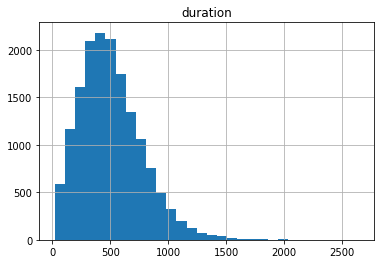

In [56]:
timeWatched.hist(column='duration',bins=30)

In [10]:
#pegar os top 25% com mais tempo assistido
top25 = timeWatched.sort_values(by='duration', ascending=False).head(int(len(timeWatched)*0.25))
top25.head()

,duration,uuid
3624,2649,26524
9876,2379,29717
3230,2372,62809
6676,2209,13311
2958,2094,15093


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E704303C50>]],
      dtype=object)

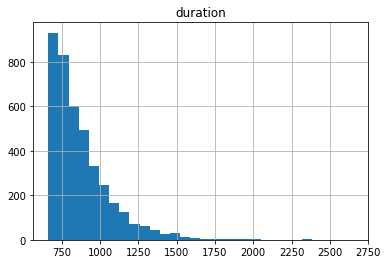

In [8]:
top25.hist(column='duration', bins=30)

Acima, temos a distribuição do tempo em que os alunos do quartil superior gastam na plataforma (Tempo em minutos X quantidade de alunos)

In [33]:
statuses = top25.merge(regs, left_on='uuid',right_on='user_uuid')
statuses.head()

,duration,uuid,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState
0,2649,26524,26524,928,2017-08-05 14:18:18,NaN,2019-06-07 15:31:44,IN_PROGRESS
1,2649,26524,26524,543,2017-08-08 07:29:22,NaN,2017-08-08 10:37:59,IN_PROGRESS
2,2649,26524,26524,49,2017-08-16 13:09:18,NaN,2017-08-19 18:10:32,IN_PROGRESS
3,2649,26524,26524,117,2017-08-16 13:45:16,NaN,2017-08-23 20:40:32,IN_PROGRESS
4,2649,26524,26524,1028,2017-10-05 15:51:58,NaN,2017-10-05 15:53:22,IN_PROGRESS


In [87]:
statuses = statuses[statuses.currentState!='NOT_VISIBLE']
statuses = statuses[statuses.currentState!='BOOKMARKED']

Aqui, fazemos a remoção de estados de curso irrelevantes para nossa análise, deixando apenas IN_PROGRESS e PAUSED a serem analisados

In [88]:
#curso completado -> com data e in_progress // curso pausado -> resto
statuses['completion'] = np.where((statuses['currentState']=='IN_PROGRESS') & (statuses['finishedAt'].notna()), 'completed', 'paused')

In [90]:
statuses.drop(['duration'],axis=1,inplace=True)
statuses.head()

,uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState,completion
0,26524,928,2017-08-05 14:18:18,NaN,2019-06-07 15:31:44,IN_PROGRESS,paused
1,26524,543,2017-08-08 07:29:22,NaN,2017-08-08 10:37:59,IN_PROGRESS,paused
2,26524,49,2017-08-16 13:09:18,NaN,2017-08-19 18:10:32,IN_PROGRESS,paused
3,26524,117,2017-08-16 13:45:16,NaN,2017-08-23 20:40:32,IN_PROGRESS,paused
4,26524,1028,2017-10-05 15:51:58,NaN,2017-10-05 15:53:22,IN_PROGRESS,paused


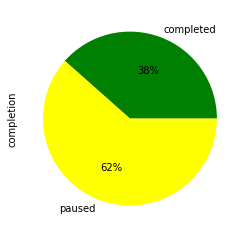

In [14]:
statuses.groupby('completion')['completion'].count().plot.pie(colors = ['green','yellow'], autopct='%1.0f%%')

In [13]:
statuses.groupby('completion')['completion'].count()

completion
completed     8475
paused       13562
Name: completion, dtype: int64

Pelo gráfico, percebe-se que a maioria dos alunos os quais consideramos "os mais estudiosos" não completam seus cursos, mas sim os pausam em pontos arbitrários, sem necessáriamente haver um critério

In [4]:
courses.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [61]:
courses.groupby('level')['level'].count()

level
1     664
5     375
10     50
Name: level, dtype: int64

In [92]:
top25_courses = top25.merge(tasks, left_on='uuid',right_on='uuid')
top25_courses = top25_courses.merge(courses, left_on='course_uuid',right_on='uuid')
top25_courses.drop(['duration_x','duration_y','createdAt_x','createdAt_y','uuid_y'],axis=1,inplace=True)
top25_courses.head()

,uuid_x,kind,status,course_uuid,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,substitute_uuid
0,26524,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
1,49929,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
2,38117,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
3,32023,VIDEO,ACTIVE,969,5,2014-11-17,152,30,PUBLISHED,0,NaN,NaN
4,29717,VIDEO,ACTIVE,818,5,2016-04-12,176,63,DISABLED,0,2020-07-17,649.0


In [26]:
top25_courses.groupby('level')['level'].count()

level
1     2357
5     1469
10     177
Name: level, dtype: int64

Temos abaixo o gráfico que ilustra uma predominância de cursos considerados "mais fáceis" dentre esse público.

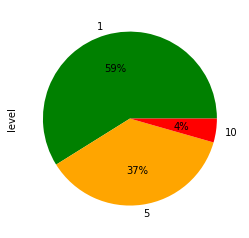

In [29]:
top25_courses.groupby('level')['level'].count().plot.pie(colors = ['green','orange','red'], autopct='%1.0f%%')

In [205]:
teste = statuses.merge(top25_courses, left_on='uuid',right_on='uuid_x')
teste.drop(['uuid_x', 'course_uuid_y'],axis=1,inplace=True)
teste['completion'] = teste['completion'].replace('completed', 1)
teste['completion'] = teste['completion'].replace('paused', 0)
teste['courseCount'] = teste.groupby('uuid')['course_uuid_x'].transform('count')
teste['completionRate'] = 100*teste.groupby(by=['uuid'])['completion'].transform('sum')/teste['courseCount']
teste = teste[['uuid','completionRate','courseCount']]
teste.drop_duplicates(subset=['uuid'],keep='first',inplace=True)
teste.head()

,uuid,completionRate,courseCount
0,26524,24.000000,25
25,15093,100.000000,3
28,47481,33.333333,15
43,11347,33.333333,3
46,26188,60.000000,5


Finalmente, temos abaixo uma distribuição ta taxa de conclusão dos cursos entre os 25% mais ativos na plataforma.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DD9FB6908>]],
      dtype=object)

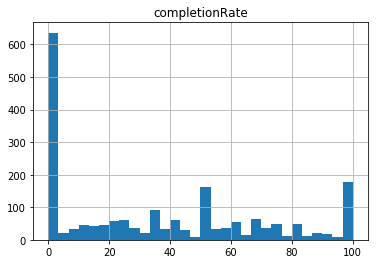

In [204]:
teste.hist(column='completionRate',bins=30)